# supernode-edges

The procedure of constructing weighted L-space and P-space edges of the supernode network.

__Warning!__ Some procedures require 16 cores and up to 10 GB RAM.

Requires:
1. `data/preprocessed/routes.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/edges_lspace.json`
2. `data/supernodes/edges_pspace_alpha_metrics.json`
3. `data/supernodes/edges_pspace.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List, Dict
from multiprocessing import Pool
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
from matplotlib import pyplot as plt

from myutils.networkx import get_layout
from myutils.spatial import get_earth_distances
from myutils.json import save_json

from ptn.parallel_centralities import shortest_paths_parallel
from config import routes_fpath, supernodes_fpath, edges_lspace_fpath, \
    edges_pspace_alpha_metrics_fpath, edges_pspace_fpath

plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('deep'))
plt.rcParams['figure.figsize'] = 5, 5

rcparams = {
    'text.usetex' : True,
    'font.family': [
        'serif'
    ],
    'font.serif': [
        'Computer Modern Roman',
        'Times',
        'Palatino',
        'New Century Schoolbook',
        'Bookman',
    ],
}

plt.rcParams.update(rcparams)

In [3]:
routes = pd.read_json(routes_fpath).set_index('id')

routes.head(2)

,name,type,direction,stops,distance,supernodes
id,,,,,,
1125,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
11125,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [4]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


### L-space

In [5]:
edges = defaultdict(int)

for route in routes['supernodes']:
    for u, v in zip(route, route[1:]):
        if u > v:
            u, v = v, u
        
        edges[(u, v)] += 1
        
edges = [
    {
        'u': u,
        'v': v,
        'w': w,
    }
    for (u, v), w in edges.items()
]

edges[:5]

[{'u': 620, 'v': 827, 'w': 6},
 {'u': 827, 'v': 828, 'w': 10},
 {'u': 20, 'v': 828, 'w': 10},
 {'u': 20, 'v': 309, 'w': 12},
 {'u': 80, 'v': 309, 'w': 12}]

In [6]:
weighted_edges = [(edge['u'], edge['v'], edge['w']) for edge in edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

(3202, 5304)

In [7]:
# pos = get_layout(g)
pos = dict(zip(supernodes.index, supernodes[['lon', 'lat']].values))

In [8]:
components = list(nx.connected_components(g.to_undirected()))
color = {node: f'C{i}' for i, comp in enumerate(components) for node in comp}

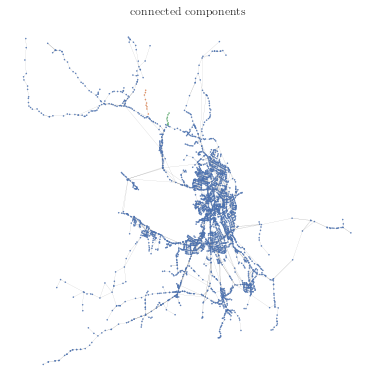

In [10]:
nx.draw(g, pos, node_size=0.25, width=0.05, node_color=[color[node] for node in g])
plt.title('connected components');

In [11]:
save_json(edges, edges_lspace_fpath)

### P-space

In [12]:
coords = supernodes[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    return distances[route[:-1], route[1:]].sum()

In [13]:
def construct_pspace_edges(alpha: float) -> List[Dict[str, float]]:
    edges = []

    for _, route in routes['supernodes'].iteritems():
        n = len(route)

        for i in range(n - 1):
            for j in range(i + 1, n):
                u = route[i]
                v = route[j]

                if u > v:
                    u, v = v, u

                subroute = route[i : j + 1]
                
                distance = get_route_distance(subroute)
                weight = 1 - alpha + alpha * distance

                edges.append((u, v, distance, weight))

    edges = pd.DataFrame(edges, columns=['u', 'v', 'distance', 'w'])\
        .sort_values(by=['u', 'v', 'w']).drop_duplicates(['u', 'v'], keep='first')

    edges = [
        {
            'u': int(row['u']),
            'v': int(row['v']),
            'w': float(row['w']),
            'distance': float(row['distance']),
        }
        for _, row in edges.iterrows()
    ]
    
    return edges

In [14]:
metrics = pd.read_json(edges_pspace_alpha_metrics_fpath).set_index('alpha')

metrics.head(2)

,distance_mean,distance_median,distance_q1,distance_q3,distance_max,hops_mean,hops_median,hops_q1,hops_q3,hops_max
alpha,,,,,,,,,,
0.010,34.603154,29.776188,17.180731,45.820028,200.557199,3.184869,3,3,4,8
0.108,33.726213,28.974031,16.788581,44.650621,200.557199,3.252099,3,3,4,8


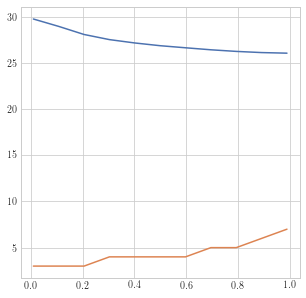

In [15]:
plt.plot(metrics['distance_median'])
plt.plot(metrics['hops_median'])

In [16]:
edges = construct_pspace_edges(alpha=0.33)

edges[:5]

[{'u': 0, 'v': 6, 'w': 8.349711464586662, 'distance': 23.271852922989886},
 {'u': 0, 'v': 8, 'w': 5.571580885524599, 'distance': 14.853275410680604},
 {'u': 0, 'v': 9, 'w': 5.285174979311074, 'distance': 13.985378725185072},
 {'u': 0, 'v': 13, 'w': 4.273017234500154, 'distance': 10.918234043939858},
 {'u': 0, 'v': 14, 'w': 4.8279504115066505, 'distance': 12.599849731838335}]

In [17]:
weighted_edges = [(edge['u'], edge['v'], edge['w']) for edge in edges]

g = nx.Graph()
g.add_weighted_edges_from(weighted_edges)

len(g), len(g.edges)

(3202, 118449)

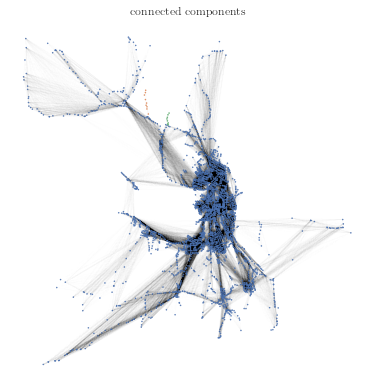

In [19]:
nx.draw(g, pos, node_size=0.25, width=0.002, node_color=[color[node] for node in g])
plt.title('connected components');

In [20]:
save_json(edges, edges_pspace_fpath)